# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from math import factorial 
from scipy import stats as st
from matplotlib import pyplot as plt # Cargar todas las librerías



## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls =  pd.read_csv('/datasets/megaline_calls.csv')
net =  pd.read_csv('/datasets/megaline_internet.csv') 
mess =  pd.read_csv('/datasets/megaline_messages.csv') 
plans =  pd.read_csv('/datasets/megaline_plans.csv') 
users =  pd.read_csv('/datasets/megaline_users.csv')


## Preparar los datos

## Tarifas

In [3]:
plans.info() # Imprime la información general/resumida sobre el DataFrame de las tarifas



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
plans.head()# Imprime una muestra de los datos para las tarifas



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate



Es un DataFrame de 2 filas y 8 columnas. La mayoria de los datos con tipo entero, los datos que son flotantes no intervienen con el analisis. No hay datos ausentes ni filas duplicadas
Una manera de enriquecer los datos es transformar de mb_per_month_included a gigabytes para facilitar los calculos posteriores.

## Corregir datos

## Enriquecer los datos

In [5]:
plans['gb_per_month_included'] = plans['mb_per_month_included']/1024
print(plans['gb_per_month_included'])

0    15.0
1    30.0
Name: gb_per_month_included, dtype: float64


## Usuarios/as

In [6]:
users.info() # Imprime la información general/resumida sobre el DataFrame de usuarios
print( )
print(users.duplicated().sum()) #Para asegurarme de que no hayan filas duplicadas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

0


In [7]:
users.head() # Imprime una muestra de datos para usuarios


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [8]:

users.describe()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


Se observa que el promedio de edad de los usuarios de las tarifas es de 45 años
y el minimo de edad es 18 y maximo de edad es 75 años


Es un DataFrame con 500 filas y 8 columnas, de las cuales solo 'churn_date' presenta datos ausentes porque es la fecha en la que el usuario dejó de usar el servicio por lo tanto el valor es ausente si la tarifa se estaba usando cuando fue extraída esta base de datos. Las columnas 'churn_date' y 'reg_date' es tipo object, las cambiare a datetime para facilitar calculos. Y los datos ausentes los cambiaria por un 0 
No existen duplicados

### Corregir los datos

In [9]:
#CHURN_DATE Y REG_DATE SE CAMBIAN DE OBJECT A DATETIME EN FORMATO (AAAA-MM-DD) 

users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer los datos

## Llamadas

In [10]:
calls.info()# Imprime la información general/resumida sobre el DataFrame de las llamadas
print()
print(calls.duplicated().sum()) #Para asegurarme de que no existan filas duplicadas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

0


In [11]:
calls.head() # Imprime una muestra de datos para las llamadas



,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [12]:
calls.describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


Los usuarios en gerneral de ambas tarifas hablan 6 minutos promedio y maximo hablan 38 minutos

ES UN DATAFRAME CON 137735 FILAS Y 4 COLUMNAS, TIENE DATOS, DEL TIPO OBJECT, ENTERO Y FLOTANTE. LA COLUMNA 'call_date' DE TIPO OBJECT LA CAMBIARE A DATETIME PARA FACILITAR EL ANALISIS Y LOS CALCULOS PORSTERIORES.
EL DATAFRAME NO TIENE VALORES AUSENTES

### Corregir los datos

In [13]:
#CALL_DATE SE CAMBIAR DE OBJECT A DATETIME 
#REDONDEAR y CAMBIAR A TIPO ENTERO LA COLUMNA 'DURATION'
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
#calls['duration'] = round(calls['duration']).astype(int)
calls['duration'] = np.ceil(calls['duration'])
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

In [14]:
from datetime import datetime
calls['month'] = calls['call_date'].dt.month
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.3+ MB


## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
mess.info()
print()
print(mess.duplicated().sum()) #Para asegurarme de que no existan filas duplicadas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB

0


In [16]:
mess.head()# Imprime una muestra de datos para los mensajes



,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26




ES UN DATAFRAME DE 76051 FILAS Y 3 COLUMNAS, NO CUENTA CON VALORES AUSENTES NI FILAS DUPLICADAS.
LA COLUMNA 'message_date' ESTA CON TIPO DE DATO OBJECT Y LA CORREGIRE A TIPO DE DATO DATETIME EN FORMATO (AAAA-MM-DD)

### Corregir los datos

In [17]:
#MESSAGE_DATE SE CAMBIA DE OBJECT A DATETIME
mess['message_date'] = pd.to_datetime(mess['message_date'], format='%Y-%m-%d')
mess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

In [18]:
mess['month'] = mess['message_date'].dt.month #Crear una columna solo con el mes de la columna message_date
mess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


## Internet

In [19]:
net.info() 
print() # Imprime la información general/resumida sobre el DataFrame de internet
print(net.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

0


In [20]:
net.head() # Imprime una muestra de datos para el tráfico de internet



,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [21]:
net.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


Los usuarios en promedio utilzan 0.35 gb y el trafico maximo que utilizan es 1.65 gigabytes 


ESTE DATAFRAME CUENTA CON 104825 FILAS Y 4 COLUMNAS, SIN DATOS AUSENTES NI FILAS DUPLICADAS.
LA COLUMNA 'session_date' SE CAMBIA A TIPO DATETIME 

### Corregir los datos

In [22]:
#CALL_DATE SE CAMBIAR DE OBJECT A DATETIME
net['session_date'] = pd.to_datetime(net['session_date'], format='%Y-%m-%d')
net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [23]:
net['month'] = net['session_date'].dt.month #Crear una columna solo con el mes de la columna session_date
net['gb_used'] = net['mb_used']/1024 #Crear una columna de gigabytes consumidas 
net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
 5   gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 4.8+ MB


## Estudiar las condiciones de las tarifas

In [24]:
plans.head()# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Agregar datos por usuario


In [25]:
#Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
num_calls = calls.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id':'n_calls_mensual'})
num_calls

,user_id,month,n_calls_mensual
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [26]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
cant_min = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index().rename(columns={'duration':'duration_min_mensual'})
cant_min

,user_id,month,duration_min_mensual
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [27]:
#Unir los minutos mensuales y las llamadas mensuales en un solo dataframe
llamadas = num_calls.merge(cant_min, on=['user_id','month'], how='outer')
llamadas

,user_id,month,n_calls_mensual,duration_min_mensual
0,1000,12,16,124.0
1,1001,8,27,182.0
2,1001,9,49,315.0
3,1001,10,65,393.0
4,1001,11,64,426.0
...,...,...,...,...
2253,1498,12,39,339.0
2254,1499,9,41,346.0
2255,1499,10,53,385.0
2256,1499,11,45,308.0


In [28]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

num_mess= mess.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id':'n_msg_mensual'})
num_mess

,user_id,month,n_msg_mensual
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [29]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
vol_net = net.groupby(['user_id', 'month'])['gb_used'].sum().reset_index().rename(columns={'gb_used':'gb_used_mensual'})
vol_net['gb_used_mensual'] = np.ceil(vol_net['gb_used_mensual'])
vol_net

,user_id,month,gb_used_mensual
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


In [30]:
#Unir de los mensajes mensuales y volumne de trafico mensual
msg_net = num_mess.merge(vol_net, on=['user_id','month'], how='outer')

In [31]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
#Hago la union de los dos dataframe anteriores 
new = llamadas.merge(msg_net, on=['user_id','month'], how='outer')
new.head()

,user_id,month,n_calls_mensual,duration_min_mensual,n_msg_mensual,gb_used_mensual
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0


In [32]:
# Añade la información de la tarifa
info = pd.merge(new,users[['user_id', 'plan', 'city']],on="user_id",how="inner").rename(columns={"plan": "plan_name"})
info_total = info.merge (plans, on= 'plan_name')
info_total.head()

,user_id,month,n_calls_mensual,duration_min_mensual,n_msg_mensual,gb_used_mensual,plan_name,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,12,16.0,124.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70,7,0.01,0.01,30.0
1,1006,11,2.0,10.0,15.0,3.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,30.0
2,1006,12,9.0,59.0,139.0,32.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,30.0
3,1008,10,71.0,476.0,21.0,17.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,30.0
4,1008,11,63.0,446.0,37.0,24.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,30.0


In [33]:
# Calcula el ingreso mensual para cada usuario

#Calculo los excesos de minutos, mensajes y gigabytes
info_total['exc_min'] = info_total["duration_min_mensual"] - info_total["minutes_included"]
info_total['exc_msg'] = info_total["n_msg_mensual"] - info_total["messages_included"]
info_total['exc_gb'] = info_total["gb_used_mensual"] - info_total["gb_per_month_included"]

#Creo la condicion que debe ser mayor a 0 sino establecer un 0 en los excesos
info_total["exc_min"] = info_total["exc_min"].where(info_total["exc_min"] > 0, 0) 
info_total["exc_msg"] = info_total["exc_msg"].where(info_total["exc_msg"] > 0, 0) 
info_total["exc_gb"] = info_total["exc_gb"].where(info_total["exc_gb"] > 0, 0) 

#Ya calculados los excesos, los multiplico por el precio de exceso
min_pay = info_total['exc_min']*info_total['usd_per_minute']
msg_pay= info_total['exc_msg']*info_total['usd_per_message']
gb_pay = info_total['exc_gb']*info_total['usd_per_gb']

#Finalmente sumo el precio el plan mensual mas todos los excesos a pagar 
info_total['ingresos'] = info_total['usd_monthly_pay'] + min_pay + msg_pay + gb_pay

info_total.head()




,user_id,month,n_calls_mensual,duration_min_mensual,n_msg_mensual,gb_used_mensual,plan_name,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,exc_min,exc_msg,exc_gb,ingresos
0,1000,12,16.0,124.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70,7,0.01,0.01,30.0,0.0,0.0,0.0,70.0
1,1006,11,2.0,10.0,15.0,3.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,30.0,0.0,0.0,0.0,70.0
2,1006,12,9.0,59.0,139.0,32.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,30.0,0.0,0.0,2.0,84.0
3,1008,10,71.0,476.0,21.0,17.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,30.0,0.0,0.0,0.0,70.0
4,1008,11,63.0,446.0,37.0,24.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,30.0,0.0,0.0,0.0,70.0


Finalmente se realizo un DataFrame uniendo los minutos, mensajes y gigabytes mensuales para poder
calcular el ingreso mensual desde cada cliente.
Este DataFrame esta agrupado por cada cliente y cada mes
Por ejemplo se puede observar que el cliente 1006 paga una tarifa ultimate de 70 uds mensuales y 
el mes de noviembre no excedio su tarifa por lo tanto pago 70usd pero el mes de diciembre excedio su limite
de gigabytes por lo tanto pago 79.52usd 

## Estudia el comportamiento de usuario

### Llamadas

<AxesSubplot:title={'center':'Duración prom mensual de llamadas por plan'}, xlabel='meses', ylabel='minutos'>

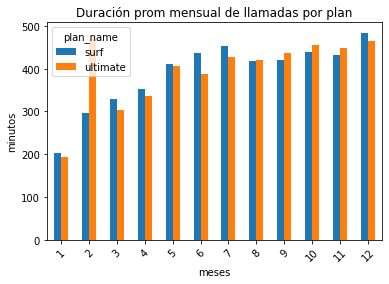

In [34]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
dur_mean = info_total.pivot_table(index='month',
                                 columns='plan_name',
                                  values='duration_min_mensual',
                                  aggfunc='mean'
                                 )
dur_mean.plot(kind='bar', 
              title='Duración prom mensual de llamadas por plan',
              xlabel='meses' , 
              ylabel= 'minutos',
              rot=45 )

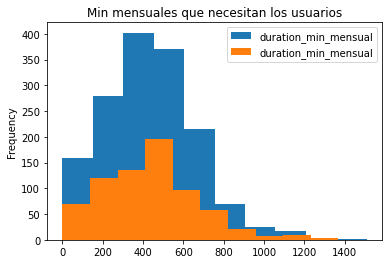

In [35]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

min_men_surf = info_total[info_total['plan_name']=='surf']['duration_min_mensual']
min_men_surf.plot(kind='hist', title= 'Min mensuales que necesitan los usuarios')
min_men_ult = info_total[info_total['plan_name']=='ultimate']['duration_min_mensual']
min_men_ult.plot(kind='hist', title= 'Min mensuales que necesitan los usuarios')
plt.legend() #('usuarios surf', 'usuarios ultimate')

In [36]:
# Calcula la media y la varianza de la duración mensual de llamadas.

prom_calls_surf = info_total.query("plan_name=='surf'")['duration_min_mensual'].mean()
prom_calls_ultimate = info_total.query("plan_name=='ultimate'")['duration_min_mensual'].mean()

#prom_calls = info_total['duration_min_mensual'].mean()

var_calls_surf = np.var(info_total.query("plan_name=='surf'")['duration_min_mensual'])
var_calls_ultimate = np.var(info_total.query("plan_name=='ultimate'")['duration_min_mensual'])

print('Minuto promedio del plan surf:', prom_calls_surf)
print('Minuto promedio del plan ultimate:', prom_calls_ultimate)
print('Varianza de los minutos mensuales del plan surf :',var_calls_surf)
print('Varianza de los minutos mensuales del plan ultimate :',var_calls_ultimate)


Minuto promedio del plan surf: 436.51974110032364
Minuto promedio del plan ultimate: 434.67601683029454
Varianza de los minutos mensuales del plan surf : 52537.03666530514
Varianza de los minutos mensuales del plan ultimate : 56494.28633925359


In [37]:
info_total.describe()

,user_id,month,n_calls_mensual,duration_min_mensual,n_msg_mensual,gb_used_mensual,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,exc_min,exc_msg,exc_gb,ingresos
count,2293.000000,2293.000000,2258.000000,2258.000000,1806.000000,2277.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1246.075883,9.172700,60.998671,435.937555,42.110188,16.989021,348.299171,20183.026603,1284.997819,35.699956,9.058003,0.023720,0.023720,19.709987,42.160925,4.810728,2.755342,64.351147
std,143.051927,2.496386,31.770869,231.972343,33.122931,7.693683,441.006389,7130.376976,1160.543128,23.210863,1.392652,0.009284,0.009284,6.963259,107.799717,16.450516,4.884966,46.624945
min,1000.000000,1.000000,1.000000,0.000000,1.000000,1.000000,50.000000,15360.000000,500.000000,20.000000,7.000000,0.010000,0.010000,15.000000,0.000000,0.000000,0.000000,20.000000
25%,1122.000000,8.000000,39.000000,275.000000,17.000000,13.000000,50.000000,15360.000000,500.000000,20.000000,7.000000,0.010000,0.010000,15.000000,0.000000,0.000000,0.000000,23.480000
50%,1245.000000,10.000000,60.000000,429.000000,34.000000,17.000000,50.000000,15360.000000,500.000000,20.000000,10.000000,0.030000,0.030000,15.000000,0.000000,0.000000,0.000000,70.000000
75%,1368.000000,11.000000,80.000000,574.750000,59.000000,21.000000,1000.000000,30720.000000,3000.000000,70.000000,10.000000,0.030000,0.030000,30.000000,0.000000,0.000000,4.000000,70.000000
max,1499.000000,12.000000,205.000000,1510.000000,266.000000,70.000000,1000.000000,30720.000000,3000.000000,70.000000,10.000000,0.030000,0.030000,30.000000,1010.000000,216.000000,55.000000,590.370000


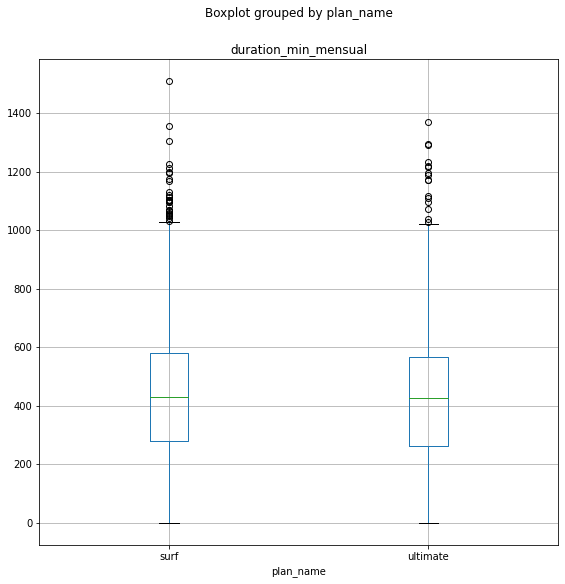

In [38]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
info_total.boxplot(column = 'duration_min_mensual' , by= 'plan_name', figsize=[9,9])
plt.show()




EN EL GRAFICO DE BARRAS PODEMOS OBSERVAR QUE LOS USUARIOS DE ULTIMATE UTILIZAN MAS MINUTOS PROMEDIOS EL MES DE FEBRERO, EN COMPARACION CON LOS USUARIOS DE SURF QUE UTILIZAN MAS MINUTOS PROMEDIOS EL MES DE DICIEMBRE. EN IGUALDAD LOS USUARIOS DE AMBOS PLANES REDUCEN EL CONSUMO DE MINUTOS PROMEDIO EL MES DE ENERO. PODEMOS UTILIZAR ESTA INFORMACION PARA ESTABLECER EN QUE MES DEL AÑO HACER MAS CAMPAÑA PUBLICITARIA DE UN PLAN MAS QUE EL OTRO
EN EL HISTOGRAMA SE OBSERVA QUE LA MAYORIA DE LOS USUARIOS DEL PLAN SURF CONSUMEN DE 300 A 450 MINUTOS PROMEDIO MENSUALES EN COMPARACION A LA MAYORIA DE LOS USUARIO DE ULTIMATE QUE UTILIZAN DE 400 A 500 APROX MINUTOS MENSUALMENTE
LOS USUARIOS SE COMPORTAN DE IGUAL MANERA AL REALIZAR LLAMADAS, YA QUE SUS PROMEDIOS DE MINUTOS MENSUALES SE DIFERENCIAN POR CASI 2 PUNTACIONES. LA VARIANZA NOS MUESTRA QUE LOS DATOS DEL PLAN ULTIMATE ESTAN MUCHO MAS DISPERSOS QUE LOS DATOS DEL PLAN SURF 
EN EL DIAGRAMA DE CAJA SE OBSERVA QUE AMBOS PLANES TIENEN UN COMPORTAMIENTO MUY PARECIDO, TIENEN UNA MEDIANA DE 400 MINUTOS PROMEDIOS Y SUS MINIMOS Y MAXIMOS SON MUY PARECIDOS.
EN CONCLUSION EL COMPORTAMIENTO EN LLAMADAS PLANES DIFIEREN EN SEGUN EL PLAN CONTRATADO


### Mensajes

<AxesSubplot:title={'center':'Numeros de mensajes mensuales'}, xlabel='meses', ylabel='minutos'>

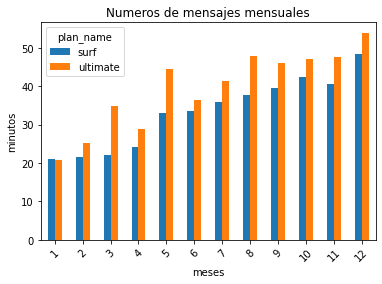

In [39]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

n_msg = info_total.pivot_table(index='month',
                                 columns='plan_name',
                                  values='n_msg_mensual',
                                  aggfunc='mean'
                                 )
n_msg.plot(kind='bar', 
              title='Numeros de mensajes mensuales',
              xlabel='meses', 
              ylabel= 'minutos',
              rot=45 )

<AxesSubplot:ylabel='Frequency'>

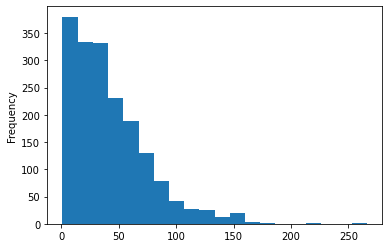

In [40]:
msg_mens = info_total['n_msg_mensual']
msg_mens.plot(kind='hist', bins=20)


In [41]:
#Calcular la media y promedio de los mensajes

msgsurf = info_total.query("plan_name=='surf'")['n_msg_mensual'].mean()
msgultimate = info_total.query("plan_name=='ultimate'")['n_msg_mensual'].mean()


var_msgsf = np.var(info_total.query("plan_name=='surf'")['n_msg_mensual'])
var_msgult = np.var(info_total.query("plan_name=='ultimate'")['n_msg_mensual'])

print('promedio de mensajes mensuales plan surf:', msgsurf)
print('promedio de mensajes mensuales plan ultimate:', msgultimate)
print(var_msgsf)
print(var_msgult)

promedio de mensajes mensuales plan surf: 40.10965630114566
promedio de mensajes mensuales plan ultimate: 46.29623287671233
1090.4511506183685
1083.3249173156314


En el diagrama de caja se puede observar esas medidas estadisticas 

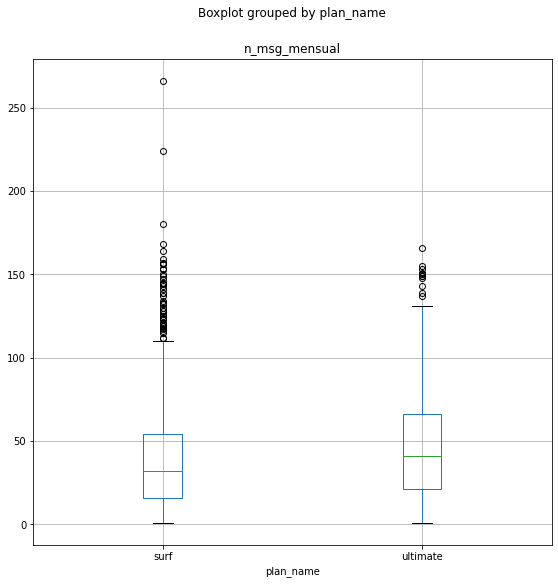

In [42]:
info_total.boxplot(column = 'n_msg_mensual' , by= 'plan_name', figsize=[9,9])
plt.show()



en el grafico de barras se observa que los usuarios de ambos planes utilizan mas mensajes en agosto, octubre y diciembre.
En el histograma se obsera que la mayoria de los usuarios envia de 0 a 20 ensajes mensuales
en el calculo de promedio, se observa una pequeña diferencia de 6 puntos de ultime sobre surf
en el diagrama de caja se observa que las mediana y los maximos de mensajes enviados mensualemnete son diferentes. 
en conclusion, el comportamiento de los usuarios con los mensajes mensuales de ambos planes no difieren segun la tarifa contratada

### Internet

<AxesSubplot:title={'center':'Cantidad mensual de trafico consumido'}, xlabel='meses', ylabel='gigabytes'>

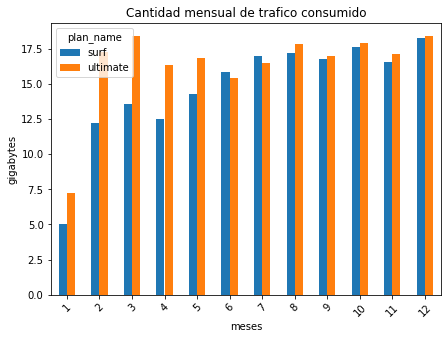

In [43]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
trf_net = info_total.pivot_table(index='month',
                                 columns='plan_name',
                                  values='gb_used_mensual',
                                  aggfunc='mean' #sum 
                                 )
trf_net.plot(kind='bar', 
              title='Cantidad mensual de trafico consumido',
              xlabel='meses' , 
              ylabel= 'gigabytes',
              rot=45, 
             figsize= [7,5])

<AxesSubplot:ylabel='Frequency'>

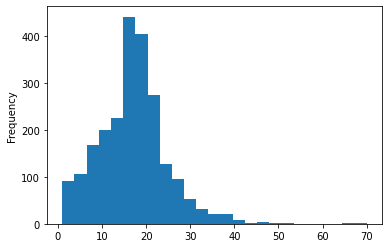

In [44]:
trf_mens = info_total['gb_used_mensual']
trf_mens.plot(kind='hist', bins=25)

In [45]:
prom_net = info_total['gb_used_mensual'].mean()
var_net = np.var(info_total['gb_used_mensual'])
print(prom_net)
print(var_net)

16.989020641194553
59.166765707523


<AxesSubplot:title={'center':'gb_used_mensual'}, xlabel='plan_name'>

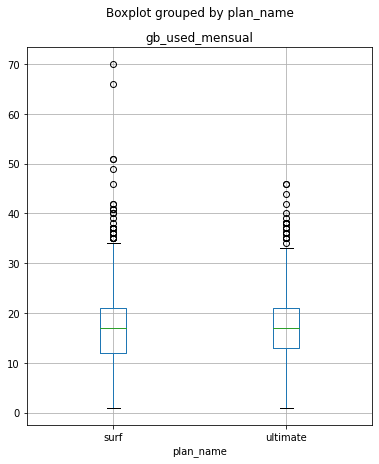

In [46]:
info_total.boxplot(column = 'gb_used_mensual' , by= 'plan_name', figsize=[6,7])

EN EL GRAFICO DE BARRAS SE OBSERVA QUE EL MAYOR CONSUMO DE LOS USUARIOS DE ULTIMATE SE REALIZA EN MARZO 
Y DICIEMBRE CON 17,5 GB APROXIMADAMENTE. Y LOS USUARIOS DEL PLAN SURF UTILIZAN DE 16 A 17 GB EN OCTUBRE Y DICIEMBRE
EN EL HISTOGRAMA Y CALCULO DE PROMEDIO SE CONFIRMA QUE LA MAYORIA DE LOS USUARIOS CONSUMEN DE 16 A 20 GB APROXIMADAMENTE
EN EL DIAGRAMA DE CAJA SE OBSERVA UN COMPORTAMIENTO PARECIDO ENTRE LOS USUARIOS DE AMBOS PLANES CON UNA 
MEDIANA DE 17GB APROXIMADAMENTE Y UN MAXIMO 33GB APROX
EN CONCLUSION LOS USUARIOS DE EL PLAN SURF CONSTANTEMENTE EXCEDEN SUS MAXIMOS DE GB EN COMPARACION
A LA MAYORIA DE LOS USUARIOS DEL PLAN ULTIMATE QUE NO ALCAZAN EL LIMITE DE GB CONSUMIDAS AL MES 


## Ingreso

<AxesSubplot:title={'center':'Ingreso promedio mensual por plan'}, xlabel='meses', ylabel='Ingresos en usd'>

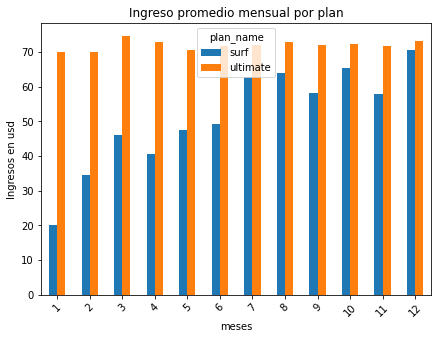

In [47]:
#crear un funcion para imprimir los graficos 
#llamar la funcion para imprimir 

income_mean = info_total.pivot_table(index='month',
                                 columns='plan_name',
                                  values='ingresos',
                                  aggfunc='mean' #sum o mean
                                 )
income_sum = info_total.pivot_table(index='month',
                                 columns='plan_name',
                                  values='ingresos',
                                  aggfunc='sum' #sum o mean
                                 )
income_mean.plot(kind='bar', 
              title='Ingreso promedio mensual por plan',
              xlabel='meses' , 
              ylabel= 'Ingresos en usd',
              rot=45, 
             figsize= [7,5])

<AxesSubplot:title={'center':'Ingresos mensuales'}, ylabel='Frequency'>

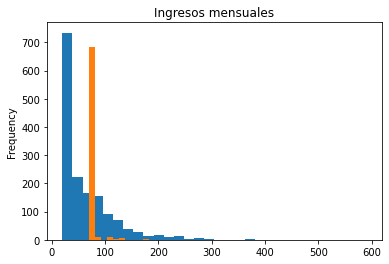

In [48]:
#ing_men = info_total['ingresos']
#ing_men.plot(kind='hist')

ing_men_surf = info_total[info_total['plan_name']=='surf']['ingresos']
ing_men_surf.plot(kind='hist', title= 'Ingresos mensuales', bins= 30)
ing_men_ult = info_total[info_total['plan_name']=='ultimate']['ingresos']
ing_men_ult.plot(kind='hist', title= 'Ingresos mensuales')

In [49]:
inggsurf = info_total.query("plan_name=='surf'")['ingresos'].mean()
ingultimate = info_total.query("plan_name=='ultimate'")['ingresos'].mean()


var_surf = np.var(info_total.query("plan_name=='surf'")['ingresos'])
var_ult = np.var(info_total.query("plan_name=='ultimate'")['ingresos'])

print('promedio de ingresos mensuales desde plan surf:', inggsurf)
print('promedio de ingresos mensuales desde plan ultimate:', ingultimate)
print(var_surf)
print(var_ult)


promedio de ingresos mensuales desde plan surf: 60.706408137317226
promedio de ingresos mensuales desde plan ultimate: 72.31388888888888
3065.8848438690247
129.66814043209877


<AxesSubplot:title={'center':'ingresos'}, xlabel='plan_name'>

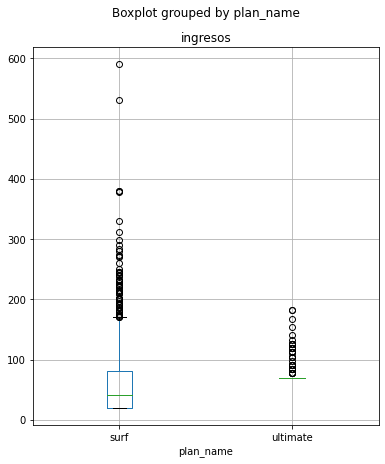

In [50]:
info_total.boxplot(column = 'ingresos' , by= 'plan_name', figsize=[6,7])

EN GRAFICO DE BARRA DE INGRESO PROMEDIO SE OBSERVA UN PARTICULAR INGRESO CONSTANTE A LO LARGO DEL AÑO 
DEL PLAN ULTIMATE, ES DECIR, QUE LOS INGRESOS DESDE LOS USUARIO DE ULTIMATE VARIAN MUY POCO, 
EN COMPARACION CON LOS INGRESOS DESDE LOS USUARIOS DE SURF QUE EN JULIO, AGOSTO, OCTUBRE Y DICIEMBRE 
AUMENTA CASI 20 DOLARES EN COMPARACION CON LOS OTROS MESES.
EN EL GRAFICO DE BARRA DE LA SUMA DE INGRESOS SE OBSERVA UNA TENDENCIA ASCENDENTE DE LOS INGRESOS 
PROCEDIENTES DE AMBOS PLANES, PERO SE OBSERVA QUE EN DICIEMBRE LOS INGRESOS DESDE EL PLAN SURF AUMENTAN 
SIGNIFICATIVAMENTE. EL TOTAL DE INGRESOS SON EN DICIEMBRE DESDE EL PLAN ULTIMATE ES APROX 11.000 DOLARES 
Y DESDE EL PLAN SURF ES SOBRE LOS 20.000 DOLARES 
EN EL HISTOGRAMA SE CONFIRMA QUE LA MAYORIA DE LOS CLIENTES DE SURF PAGAN DE 20 A 40 DOLARES MENSUALES Y 
LA MAYORIA DE LOS CLIENTES DE ULTIMATE PAGAN 70 DOLARES 

EL USUARIO DEL PLAN SURF EN PROMEDIO PAGA 57,3 DOLARES MENSUALES EN COMPARACION CON EL USUARIO DE
PLAN ULTIMATE QUE PAGA 72 DOLARES MENSUALES, CON ESTO PODEMOS CONCLUIR QUE LOS USUARIOS DE SURF 
EXCEDEN SUS LIMITES MENSUALES DEL PLAN.

EN CONCLUSION LOS INGRESOS DIFIEREN SEGUN EL PLAN 

## Prueba las hipótesis estadísticas

Prueba de diferencia de las medias de dos poblaciones

Hipotesis nula (H0) plantea que el ingreso promedio de surf es igual al ingreso promedio de ultimate
H0 = ingrprom_surf = ingprom_ultime 

Hipotesis alternativa (H1) plantea que el ingreso promedio de surf es distinto al ingreso promedio de ultimate
H1 = ingrprom_surf =! ingprom_ultime

In [51]:
# Prueba las hipótesis

ingr_surf = info_total.query("plan_name == 'surf'")["ingresos"]
ingr_ultimate = info_total.query("plan_name == 'ultimate'")["ingresos"]

#Calculo de las varianzas para saber si utilizo el parametro equal_var
var_ingr_surf = np.var(ingr_surf)
var_ingr_ultimate = np.var(ingr_ultimate)
print(var_ingr_surf)
print(var_ingr_ultimate)



3065.8848438690247
129.66814043209877


In [53]:
alpha = 0.05
pruebat = st.ttest_ind(ingr_surf, ingr_ultimate, equal_var = 'False')
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 2.862674510698644e-08
Rechazo la hipotesis


Gracias a la prueba t-student, rechazamos la hipotesis nula que dice que los ingresos promedios de surf 
son iguales a los ingresos promedios de ultimate

Prueba de diferencia de las medias de dos poblaciones

Hipotesis nula plantea que los ingresos promedios del area NY-NJ son iguales a los ingresos promedio de todas
las demas areas.
H0 = (ny_prom = demas_prom)


Hipotesis alternativa plantea que los ingresos promedios del area NY-NJ son diferentes a los ingresos promedio de todas las demas areas.
H1 = ny_prom =! demas_prom

In [54]:
# Prueba las hipótesis


ny = info_total[info_total['city'].str.contains('NY-NJ')]['ingresos']

demas = info_total[~info_total['city'].str.contains('NY-NJ')]['ingresos']

#Calculo de las varianzas para saber si utilizo el parametro equal_v
var_ny = np.var(ny)
var_demas = np.var(demas)
print(var_ny)
print(var_demas)



1890.5177172681153
2223.8866958162175


In [55]:
alpha= 0.05
pruebat = st.ttest_ind(ny, demas)
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')


valor p: 0.04355743162134274
Rechazo la hipotesis


Se rechaza la hipotesis nula que dice que los ingresos promedios del area NY-NJ son iguales a los ingresos 
promedio de todas las demas areas.

## Conclusión general


SE RECHAZA LA HIPOTESIS QUE SON IGUALES LOS INGRESOS PROMEDIOS PROCEDENTES DE LOS USUARIOS ULTIMATE Y SURF
SE RECHAZA LA HIPOTESIS QUE EL INGRESO PROMEDIO DE LOS USUARIOS DE NY-NJ ES IGUAL AL DE LOS USUARIOS DE OTRAS REGIONES

Conclusiones: 

LOS INGRESOS EN EXCESO DEL PLAN SURF NO SON TANTOS COMO EN EL PLAN ULTIMATE, LOS CLIENTES DE LA TARIFA SURF ESTAN GENERANDO MAS INGRESOS GRACIAS A SUS EXCESOS EN LOS LIMITES DE LA TARIFA
SI LOS USUARIOS DE SURF ESTAN CONSTANTEMENTE EXCEDIENDO SU CONSUMO DEL PLAN SURF ES CONVENIENTE SUGERIR QUE SE CAMBIE DE ULTIMATE 
TAMBIEN HAY USUARIOS DEL PLAN ULTIMATE QUE NO EXCEDE LOS MAXIMOS NI TAMPOCO UTILIZA EL TOTAL DE SUS MINUTOS, MESAJES NI GB INCLUIDOS, POR LO TANTO SE PUEDE SUGERIR AL CLIENTE CAMBIAR AL PLAN SURF Y FIDELIZANDO AL CLIENTE EN EL LARGO PLAZO 

DE ACUERDO CON EL ANALSIS REALIZADO, SE PUEDE CONCLUIR QUE LOS INGRESOS POR TARIFA DEPENDE DEL MES, YA QUE 
LA TARIFA ULTIMATE ES MAS UTILIZADA EN EL MES DE FEBRERO, MARZO Y DICIEMBRE. Y LA TARIFA SURF ES MAS UTILIZADA ES LOS MESES OCTUBRE Y DICIEMBRE. 

LOS INGRESOS PROMEDIO DE ULTIMATE SE MANTIENEN CONSTANTES Y LOS INGRESOS DE LA TARIFA SURF
VARIA EN LOS MESES JULIO, AGOSTO, OCTUBRE Y DICIEMBRE AUMENTA CASI 20 DOLARES EN COMPARACION CON LOS OTROS MESES 

CUAL DE LAS TARIFAS GENERA MAS INGRESOS? EL PLAN SURF ES LA TARIFA QUE MAS INGRESOS ESTA GENERANDO PORQUE LOS
USUARIOS EXCEDEN CONSTANTEMENTE SUS LIMITES ESTABLECIDOS Y PAGAN POR SUS EXCESOS. 
SE RECOMIENDA AL DEPARTAMENTO DE MARKETING AJUSTAR SU PRESUPUESTO PARA AUMENTAR LAS GANANCIAS EN LOS MESES 
QUE MENOS UTILIZADAS SON LAS TARIFAS, COMO EN LOS MESES ENERO, MAYO JUNIO, 


